# Preprocess ArcticDEM strips

In [1]:
import subprocess
from glob import glob
import os
from tqdm.auto import tqdm
import xdem
import pyproj
import geoutils as gu
import matplotlib.pyplot as plt

/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define inputs, outputs, settings

In [2]:
# Path to "data" in local directory, meant to mimic the shared Google Drive "data" folder
data_path = "/Volumes/LaCie/raineyaberle/Research/Hubbard/data" 

# ArcticDEM strips (~100 GB, not on Google Drive)
arcticdem_files = sorted(glob(os.path.join(data_path, "DEMs", "ArcticDEM_PGC_filtered", "WV0*", "*dem_masked_clip.tif")))
print(f"Total number of ArcticDEM strips = {len(arcticdem_files)}")

# IfSAR DEM
ifsar_file = os.path.join(data_path, "DEMs", "ifsar_hubbardDEM.tif")
print(f"IfSAR located = {os.path.exists(ifsar_file)}")

# Target CRS for output DEM mosaics
out_crs = "EPSG:3338" # Alaska Albers

# Glacier boundaries 
aoi_file = os.path.join(data_path, "RGI60-01.14443_outline.shp")
aoi_clipped_file = aoi_file.replace(".shp", "_clipped.gpkg")

# Output path
out_path = os.path.join(data_path, "DEMs")

Total number of ArcticDEM strips = 119
IfSAR located = True


## Coregister ArcticDEM strips to IfSAR DEM

IfSAR loaded
Clipped glacier boundaries loaded from file.


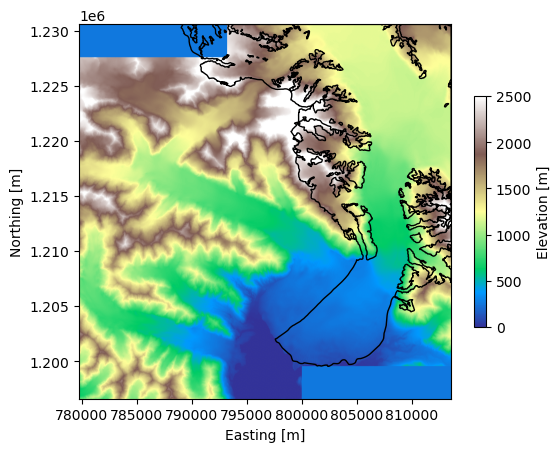

In [3]:
# --- Define path for outputs ---
os.makedirs(out_path, exist_ok=True)
out_coreg_path = os.path.join(out_path, "coregistered_strips")
os.makedirs(out_coreg_path, exist_ok=True)

# --- Load IFSAR DEM ---
# Load IFSAR DEM
ifsar = xdem.DEM(ifsar_file)
# tell XDEM what vertical projection it's in
ifsar.set_vcrs(pyproj.CRS("EPSG:5703"))
# Convert vcrs from geoid to ellipsoid to match ArcticDEM
ifsar.to_vcrs("Ellipsoid")
print("IfSAR loaded")

# --- Load clipped glacier boundaries ---
# Check if clipped boundaries already exists in directory
if not os.path.exists(aoi_clipped_file):
    print("Clipping glacier boundaries to IfSAR bounds")
    # Define clipping box from IfSAR bounds
    xmin, xmax = ifsar.bounds.left, ifsar.bounds.right
    ymin, ymax = ifsar.bounds.bottom, ifsar.bounds.top

    # Load glacier boundaries
    aoi = gu.Vector(aoi_file)
    aoi = aoi.to_crs("EPSG:3338")

    # Clip
    aoi_clipped = aoi.crop(crop_geom=(xmin, ymin, xmax, ymax))

    # Save to file
    aoi_clipped.save(aoi_clipped_file)
    print('Clipped glacier boundaries saved to file:', aoi_clipped_file)

else:
    # Load from file
    aoi_clipped = gu.Vector(aoi_clipped_file)
    print('Clipped glacier boundaries loaded from file.')

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(ifsar.data, cmap="terrain", clim=(0, 2.5e3),
                   extent=(
                       ifsar.bounds.left, ifsar.bounds.right, 
                       ifsar.bounds.bottom, ifsar.bounds.top
                       ))
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m]')
aoi_clipped.plot(ax=ax, facecolor='None', edgecolor='k')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
plt.show()


In [4]:
# --- Convert clipped AOI to inlier mask ---
aoi_clipped_mask = aoi_clipped.create_mask(ifsar)

# --- Iterate over ArcticDEM strips ---
print("Coregistering ArcticDEM strips")
for file in tqdm(arcticdem_files):
    # Define output file
    arcticdem_coreg_file = os.path.join(
        out_coreg_path, 
        os.path.splitext(os.path.basename(file))[0] + "_coreg.tif"
        )
    if os.path.exists(arcticdem_coreg_file):
        print(f"Coregistered ArcticDEM strip already exists in file, skipping: {arcticdem_coreg_file}")
        continue

    # Load ArcticDEM strip
    arcticdem = xdem.DEM(file)

    # Reproject to match IfSAR CRS
    arcticdem = arcticdem.reproject(ifsar)

    # Coregister using Nuth and Kaab, mask glacier surface
    nuth_kaab = xdem.coreg.NuthKaab()
    try:
        nuth_kaab.fit(ifsar, arcticdem, inlier_mask=~aoi_clipped_mask) # Fit the data to a suitable x/y/z offset
        aligned_dem = nuth_kaab.apply(arcticdem) # Apply the transformation to the DEM
    except Exception as e:
        print(e)
        continue

    # Save coregistered DEM to file
    aligned_dem.to_file(arcticdem_coreg_file, driver='GTiff', dtype='int64', nodata=-9999)
    print('Coregistered DEM saved to file: ', arcticdem_coreg_file)


Coregistering ArcticDEM strips


  0%|          | 0/119 [00:00<?, ?it/s]

Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20130522_10200100223B5E00_102001002182CE00_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20130526_1020010023316100_1020010024AFB800_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20130625_1020010022E0EC00_102001002255DA00_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20130810_10200100256EAD00_1020010023DBD100_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file,

  6%|▌         | 7/119 [00:00<00:15,  7.28it/s]

'dem_to_be_aligned' had only NaNs
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20141111_10200100372DFA00_1020010034C59500_2m_lsf_seg2_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20141120_10200100394F6300_1020010036C03A00_2m_lsf_seg2_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20151031_102001004377FC00_1020010043745200_2m_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20151031_1020010045AAB800_10200100467B3700_2m_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM str

/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/xdem/coreg/affine.py:504: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)
 24%|██▍       | 29/119 [00:05<00:18,  4.98it/s]

The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.


/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/xdem/coreg/affine.py:504: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)
 25%|██▌       | 30/119 [00:10<00:37,  2.37it/s]

The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.


/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/xdem/coreg/affine.py:504: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)
 26%|██▌       | 31/119 [00:14<00:58,  1.51it/s]

The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20210223_10200100A14A8200_10200100A4011000_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20210223_10200100A14A8200_10200100A4011000_2m_lsf_seg2_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20220130_10200100BD227D00_10200100BFD40A00_2m_lsf_seg1_dem_masked_clip_coreg.tif


 29%|██▉       | 35/119 [00:16<00:51,  1.65it/s]

All values of the inlier mask are NaNs in either 'reference_dem' or 'dem_to_be_aligned'.
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20220412_10200100C0DE6900_10200100C2744000_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20220429_10200100C263E600_10200100C4AD4800_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20220611_10200100C545CF00_10200100C6934D00_2m_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV01_20221116_10200100CD18CD00_10200100CE8EC300_2m_se

/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/xdem/coreg/affine.py:504: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)
 43%|████▎     | 51/119 [00:19<00:24,  2.77it/s]

The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV02_20151123_103001004D534700_103001004C953B00_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV02_20160510_1030010055A18F00_1030010056ABB300_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV02_20160510_1030010055A18F00_1030010056ABB300_2m_lsf_seg2_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Vo

/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/xdem/coreg/affine.py:504: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)
 61%|██████▏   | 73/119 [00:23<00:12,  3.77it/s]

The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.


/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/xdem/coreg/affine.py:504: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)
100%|██████████| 119/119 [00:27<00:00,  4.28it/s]

The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV02_20210122_10300100B088E800_10300100B43B4300_2m_lsf_seg3_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV02_20210127_10300100B2B3CB00_10300100B591DB00_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Volumes/LaCie/raineyaberle/Research/Hubbard/data/DEMs/coregistered_strips/SETSM_s2s041_WV02_20210210_10300100B229E300_10300100B4047B00_2m_lsf_seg1_dem_masked_clip_coreg.tif
Coregistered ArcticDEM strip already exists in file, skipping: /Vo

## Mosaic coregistered strips captured same day

In [5]:
# Create subfolder for mosaics
out_mosaic_path = os.path.join(out_path, "mosaics")
os.makedirs(out_mosaic_path, exist_ok=True)

# Get the coregistered strips
arcticdem_coreg_files = sorted(glob(os.path.join(out_coreg_path, "*.tif")))

# Grab unique image dates from file names
dates = [os.path.basename(fn)[18:26] for fn in arcticdem_files]
dates_unique = sorted(list(set(dates)))
print(f"Identified {len(dates_unique)} unique DEM dates")

# Iterate over unique image dates
print("Mosaicking coregistered ArcticDEM strips...")
for date in tqdm(dates_unique):
    # Grab all files names with image date in file name
    dem_files_date = [x for x in arcticdem_files if date in os.path.basename(x)]
        
    # Define output file name
    mosaic_file = os.path.join(out_mosaic_path, date + "_ArcticDEM_mosaic.tif")
    
    # Check if file already exists in directory
    if os.path.exists(mosaic_file):
        print("Mosaic already exists for date, skipping...")
        continue
        
    # Construct gdalwarp command
    cmd = "gdalwarp "
    # add input file names
    cmd += " ".join(dem_files_date)
    # add target CRS
    cmd += f" -t_srs {out_crs}"
    # add output file name
    cmd += f" {mosaic_file}"
    # print(cmd)
    
    # Run command
    output = subprocess.run(cmd, shell=True, capture_output=True)
    print(output) 

Identified 99 unique DEM dates
Mosaicking coregistered ArcticDEM strips...


100%|██████████| 99/99 [00:00<00:00, 5776.96it/s]

Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, skipping...
Mosaic already exists for date, 

In [ ]:
# Plot some example mosaics
mosaic_files = sorted(glob(os.path.join(out_mosaic_path, "*.tif")))
for file in mosaic_files[0:5]:
    dem = xdem.DEM(file)
    fig, ax = plt.subplots()
    dem.plot(ax=ax, cmap="terrain", vmin=0, vmax=1500)
    ax.set_title(os.path.basename(file))
    plt.show()